In [ ]:
#Research Questions 
#This analysis is guided by the following research questions 
#1. What are the crucial predictive factors that must significantly influence price sensitivity and customer purchasing decisions in e-commerce environment?
#2. How can competitive pricing intelligence be systematically incorporated with customer behaviour analytics to create dynamic pricing strategies?
#3. What methodological approaches are effective for modelling demand flunctuations and predicting optimal pricing points across different customer segments and product categories?
#4. How do organisations evaluate and measure the impact of implementing different predictive analytics pricing strategies compared to traditional pricing approaches? 

In [137]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
# Optional for prettier plots
sns.set(style="whitegrid")
%matplotlib inline 
!pip install xgboost
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from datetime import date

In [138]:

# Data Loading and Exploration
def load_and_explore_data(filepath):
    print("\n1. DATA LOADING AND INITIAL EXPLORATION")
    print("-" * 50)
    
    # Load data
    df = pd.read_csv(filepath, encoding='ISO-8859-1')
    
    # Basic exploration
    print("Shape of data:", df.shape)
    print("\nFirst 5 rows:")
    print(df.head())
    print("\nData types:")
    print(df.dtypes)
    
    return df
 # Check for missing values
    print(f"\nMissing Values Analysis:")
    missing_data = df.isnull().sum()
    missing_percentage = (missing_data / len(df)) * 100
    missing_df = pd.DataFrame({
        'Missing Count': missing_data,
        'Missing Percentage': missing_percentage
    })
    print(missing_df[missing_df['Missing Count'] > 0])
    
    return df

# Call the function with correct file path
file_path = "C:/Users/ahman/Downloads/datafile/data.csv"
data = load_and_explore_data(file_path)


1. DATA LOADING AND INITIAL EXPLORATION
--------------------------------------------------
Shape of data: (541909, 8)

First 5 rows:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  

Data types:
InvoiceNo       object
StockCode       object
Description     obje

In [139]:

def preprocess_data(df):
    """
    Load the e-commerce dataset and perform initial exploration
    """
    print("\n2. DATA PREPROCESSING AND CLEANING")
    print("-" * 50)
    
    df_processed = df.copy()
    initial_records = len(df_processed)
    df_processed = df_processed.dropna(subset=['CustomerID'])
    after_customer_filter = len(df_processed)
    print(f"✓ Removed {initial_records - after_customer_filter:,} rows with missing Customer IDs")

    negative_qty = len(df_processed[df_processed['Quantity'] < 0])
    df_processed = df_processed[df_processed['Quantity'] > 0]
    print(f"✓ Removed {negative_qty:,} cancellation records (negative quantities)")

    zero_price = len(df_processed[df_processed['UnitPrice'] <= 0])
    df_processed = df_processed[df_processed['UnitPrice'] > 0]
    print(f"✓ Removed {zero_price:,} records with zero or negative unit prices")

    df_processed['InvoiceDate'] = pd.to_datetime(df_processed['InvoiceDate'])
    df_processed['Year'] = df_processed['InvoiceDate'].dt.year
    df_processed['Month'] = df_processed['InvoiceDate'].dt.month
    df_processed['Day'] = df_processed['InvoiceDate'].dt.day
    df_processed['DayOfWeek'] = df_processed['InvoiceDate'].dt.dayofweek
    df_processed['Hour'] = df_processed['InvoiceDate'].dt.hour
    df_processed['Quarter'] = df_processed['InvoiceDate'].dt.quarter
    print("✓ Created time-based features")

    df_processed['Revenue'] = df_processed['Quantity'] * df_processed['UnitPrice']
    df_processed['LogRevenue'] = np.log1p(df_processed['Revenue'])
    df_processed['LogPrice'] = np.log1p(df_processed['UnitPrice'])
    df_processed['LogQuantity'] = np.log1p(df_processed['Quantity'])
    print("✓ Created derived metrics")

    customer_features = df_processed.groupby('CustomerID').agg({
        'Revenue': ['sum', 'mean', 'count'],
        'Quantity': ['sum', 'mean'],
        'UnitPrice': ['mean', 'std'],
        'InvoiceDate': ['min', 'max']
    }).reset_index()

    customer_features.columns = ['CustomerID', 'TotalRevenue', 'AvgRevenue', 'TransactionCount',
                                 'TotalQuantity', 'AvgQuantity', 'AvgPrice', 'PriceStd',
                                 'FirstPurchase', 'LastPurchase']
    customer_features['CustomerLifespan'] = (customer_features['LastPurchase'] -
                                             customer_features['FirstPurchase']).dt.days

    df_processed = df_processed.merge(customer_features, on='CustomerID', how='left')
    print("✓ Created customer-level aggregated features")

    le_country = LabelEncoder()
    df_processed['CountryEncoded'] = le_country.fit_transform(df_processed['Country'])
    print("✓ Encoded Country")

    def remove_outliers(df, column):
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        return df[(df[column] >= Q1 - 1.5 * IQR) & (df[column] <= Q3 + 1.5 * IQR)]

    before_outlier = len(df_processed)
    for col in ['Revenue', 'Quantity', 'UnitPrice']:
        df_processed = remove_outliers(df_processed, col)
    after_outlier = len(df_processed)
    print(f"✓ Removed {before_outlier - after_outlier:,} outlier records")

    print(f"\nFinal processed dataset shape: {df_processed.shape}")
    print(f"Data quality improvement: {(len(df_processed)/initial_records)*100:.1f}% of original data retained")

    return df_processed, le_country

In [140]:
cleaned_data, encoder = preprocess_data(data)


2. DATA PREPROCESSING AND CLEANING
--------------------------------------------------
✓ Removed 135,080 rows with missing Customer IDs
✓ Removed 8,905 cancellation records (negative quantities)
✓ Removed 40 records with zero or negative unit prices
✓ Created time-based features
✓ Created derived metrics
✓ Created customer-level aggregated features
✓ Encoded Country
✓ Removed 69,246 outlier records

Final processed dataset shape: (328638, 29)
Data quality improvement: 60.6% of original data retained


In [141]:
def exploratory_analysis(df):
    """
    Comprehensive exploratory data analysis
    """
    print("\n3. EXPLORATORY DATA ANALYSIS")
    print("-" * 50)
    
    # Basic statistics
    print("\nRevenue Statistics:")
    print(df['Revenue'].describe())
    
    print("\nPrice Statistics:")
    print(df['UnitPrice'].describe())
    
    print("\nQuantity Statistics:")
    print(df['Quantity'].describe())

    # --- Distribution Plots ---
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1)
    sns.histplot(df['Revenue'], bins=50, kde=True)
    plt.title('Revenue Distribution')
    
    plt.subplot(1, 3, 2)
    sns.histplot(df['UnitPrice'], bins=50, kde=True, color='orange')
    plt.title('Unit Price Distribution')
    
    plt.subplot(1, 3, 3)
    sns.histplot(df['Quantity'], bins=50, kde=True, color='green')
    plt.title('Quantity Distribution')
    
    plt.tight_layout()
    plt.show()
    
    # Time-based analysis
    print("\nTemporal Analysis:")
    print(f"Date range: {df['InvoiceDate'].min()} to {df['InvoiceDate'].max()}")
    print(f"Total days: {(df['InvoiceDate'].max() - df['InvoiceDate'].min()).days}")

    df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')
    monthly_revenue = df.groupby('InvoiceMonth')['Revenue'].sum()

    plt.figure(figsize=(10, 4))
    monthly_revenue.plot(kind='line', marker='o')
    plt.title('Monthly Revenue Trend')
    plt.xlabel('Month')
    plt.ylabel('Revenue')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Country analysis
    print("\nTop 10 Countries by Revenue:")
    country_revenue = df.groupby('Country')['Revenue'].sum().sort_values(ascending=False).head(10)
    print(country_revenue)

    plt.figure(figsize=(10, 5))
    sns.barplot(x=country_revenue.values, y=country_revenue.index, palette='viridis')
    plt.title('Top 10 Countries by Revenue')
    plt.xlabel('Revenue')
    plt.ylabel('Country')
    plt.tight_layout()
    plt.show()
    
    # Product analysis
    print("\nTop 10 Products by Revenue:")
    product_revenue = df.groupby('Description')['Revenue'].sum().sort_values(ascending=False).head(10)
    print(product_revenue)

    plt.figure(figsize=(10, 5))
    sns.barplot(x=product_revenue.values, y=product_revenue.index, palette='magma')
    plt.title('Top 10 Products by Revenue')
    plt.xlabel('Revenue')
    plt.ylabel('Product')
    plt.tight_layout()
    plt.show()

    
    # Customer analysis
    print("\nCustomer Analysis:")
    print(f"Total unique customers: {df['CustomerID'].nunique():,}")
    print(f"Average revenue per customer: £{df.groupby('CustomerID')['Revenue'].sum().mean():.2f}")
    print(f"Average transactions per customer: {df.groupby('CustomerID').size().mean():.1f}")
    
    return True


3. EXPLORATORY DATA ANALYSIS
--------------------------------------------------

Revenue Statistics:
count    328638.000000
mean         11.204715
std           8.786427
min           0.001000
25%           3.750000
50%           9.900000
75%          16.500000
max          42.400000
Name: Revenue, dtype: float64

Price Statistics:
count    328638.000000
mean          2.131113
std           1.501096
min           0.001000
25%           1.250000
50%           1.650000
75%           2.950000
max           7.500000
Name: UnitPrice, dtype: float64

Quantity Statistics:
count    328638.000000
mean          7.200564
std           6.591111
min           1.000000
25%           2.000000
50%           5.000000
75%          12.000000
max          27.000000
Name: Quantity, dtype: float64


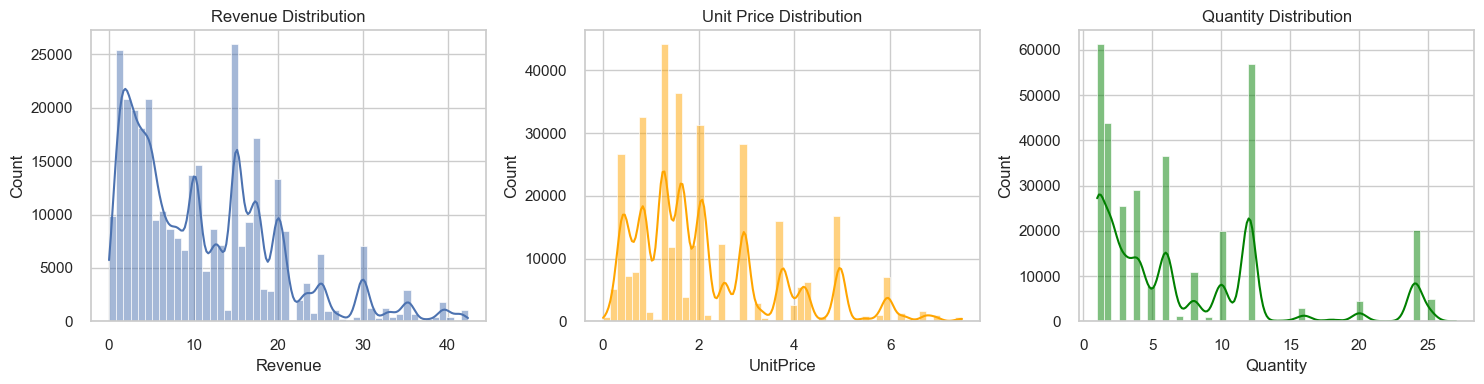


Temporal Analysis:
Date range: 2010-12-01 08:26:00 to 2011-12-09 12:50:00
Total days: 373


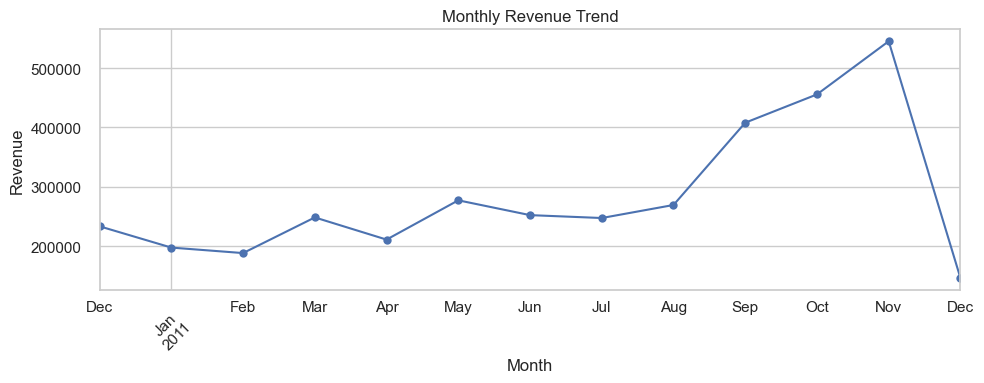


Top 10 Countries by Revenue:
Country
United Kingdom    3167477.214
Germany            118751.040
France             107325.770
EIRE                86581.640
Spain               27926.180
Belgium             26389.540
Switzerland         24059.460
Portugal            18575.870
Norway              12983.770
Italy               10777.560
Name: Revenue, dtype: float64


C:\Users\ahman\AppData\Local\Temp\ipykernel_13776\1221306126.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=country_revenue.values, y=country_revenue.index, palette='viridis')


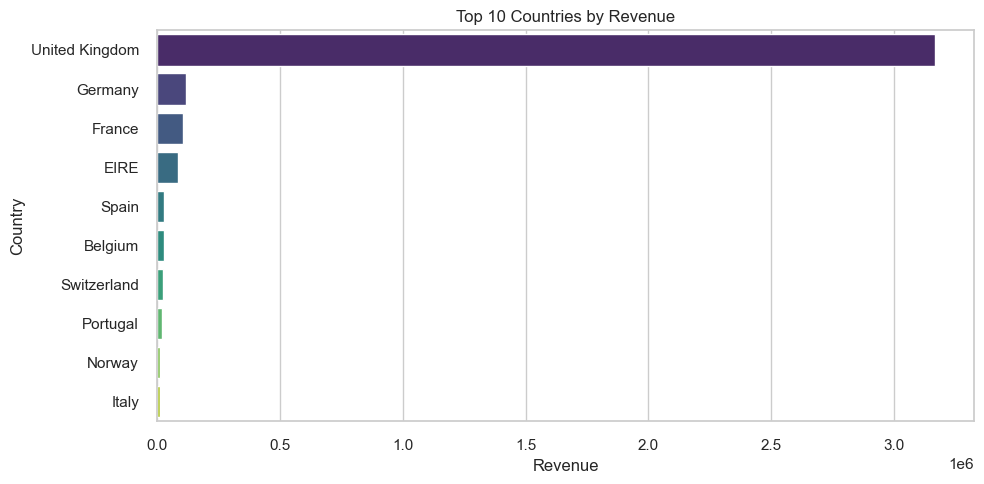


Top 10 Products by Revenue:
Description
WHITE HANGING HEART T-LIGHT HOLDER    27031.26
JUMBO BAG RED RETROSPOT               24784.14
ASSORTED COLOUR BIRD ORNAMENT         23016.11
PARTY BUNTING                         22605.45
LUNCH BAG RED RETROSPOT               16229.45
NATURAL SLATE HEART CHALKBOARD        15750.36
SET OF 3 CAKE TINS PANTRY DESIGN      15447.12
SPOTTY BUNTING                        14572.80
PAPER CHAIN KIT 50'S CHRISTMAS        13265.05
JAM MAKING SET WITH JARS              13189.25
Name: Revenue, dtype: float64


C:\Users\ahman\AppData\Local\Temp\ipykernel_13776\1221306126.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=product_revenue.values, y=product_revenue.index, palette='magma')


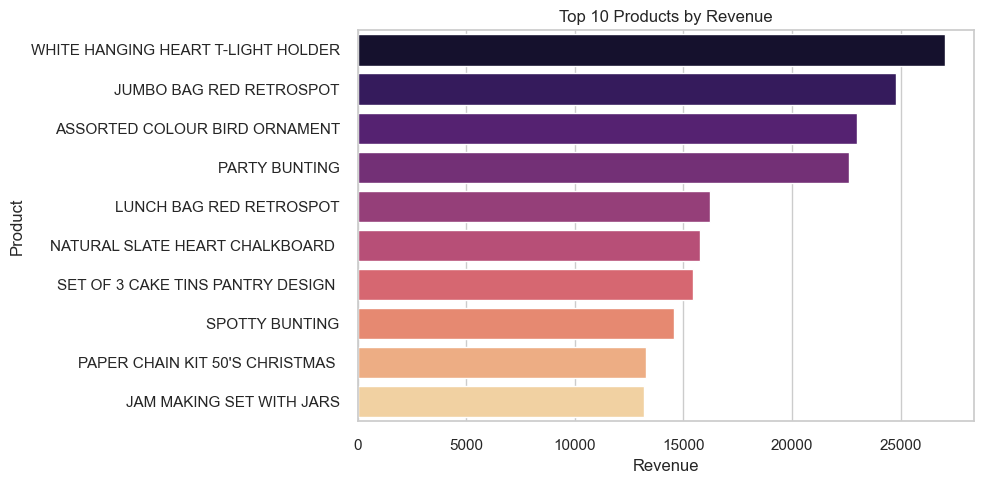


Customer Analysis:
Total unique customers: 4,154
Average revenue per customer: £886.45
Average transactions per customer: 79.1


True

In [142]:
exploratory_analysis(cleaned_data)

In [143]:
def create_visualizations(df):
    """
    Create comprehensive visualizations for data understanding
    """
    print("\n4. DATA VISUALIZATION")
    print("-" * 50)
    
    # Set up the plotting style
    plt.style.use('seaborn-v0_8')
    fig = plt.figure(figsize=(20, 24))
    
    # 1. Revenue distribution
    plt.subplot(4, 3, 1)
    plt.hist(df['Revenue'], bins=50, alpha=0.7, color='skyblue')
    plt.title('Revenue Distribution')
    plt.xlabel('Revenue (£)')
    plt.ylabel('Frequency')
    plt.yscale('log')
    
    # 2. Log Revenue distribution (more normal)
    plt.subplot(4, 3, 2)
    plt.hist(df['LogRevenue'], bins=50, alpha=0.7, color='lightgreen')
    plt.title('Log Revenue Distribution')
    plt.xlabel('Log Revenue')
    plt.ylabel('Frequency')
    
    # 3. Price vs Quantity scatter
    plt.subplot(4, 3, 3)
    sample_data = df.sample(n=min(5000, len(df)))  # Sample for performance
    plt.scatter(sample_data['UnitPrice'], sample_data['Quantity'], alpha=0.5, s=1)
    plt.title('Price vs Quantity Relationship')
    plt.xlabel('Unit Price (£)')
    plt.ylabel('Quantity')
    plt.xscale('log')
    plt.yscale('log')
    
    # 4. Monthly revenue trend
    plt.subplot(4, 3, 4)
    monthly_revenue = df.groupby(['Year', 'Month'])['Revenue'].sum().reset_index()
    monthly_revenue['Date'] = pd.to_datetime(monthly_revenue[['Year', 'Month']].assign(day=1))
    plt.plot(monthly_revenue['Date'], monthly_revenue['Revenue'], marker='o')
    plt.title('Monthly Revenue Trend')
    plt.xlabel('Date')
    plt.ylabel('Total Revenue (£)')
    plt.xticks(rotation=45)
    
    # 5. Top countries by revenue
    plt.subplot(4, 3, 5)
    top_countries = df.groupby('Country')['Revenue'].sum().sort_values(ascending=False).head(10)
    plt.barh(range(len(top_countries)), top_countries.values)
    plt.yticks(range(len(top_countries)), top_countries.index)
    plt.title('Top 10 Countries by Revenue')
    plt.xlabel('Total Revenue (£)')
    
    # 6. Hour of day analysis
    plt.subplot(4, 3, 6)
    hourly_revenue = df.groupby('Hour')['Revenue'].sum()
    plt.bar(hourly_revenue.index, hourly_revenue.values, color='orange')
    plt.title('Revenue by Hour of Day')
    plt.xlabel('Hour')
    plt.ylabel('Total Revenue (£)')
    
    # 7. Day of week analysis
    plt.subplot(4, 3, 7)
    day_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday',
               4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
    daily_revenue = df.groupby('DayOfWeek')['Revenue'].sum()
    daily_revenue.index = daily_revenue.index.map(day_mapping)
    plt.bar(daily_revenue.index, daily_revenue.values, color='purple')
    plt.xticks(rotation=45)
    plt.title('Revenue by Day of Week')
    plt.ylabel('Total Revenue (£)')
    
    # 8. Customer segmentation by revenue
    plt.subplot(4, 3, 8)
    customer_revenue = df.groupby('CustomerID')['Revenue'].sum()
    plt.hist(customer_revenue, bins=50, alpha=0.7, color='red')
    plt.title('Customer Revenue Distribution')
    plt.xlabel('Total Customer Revenue (£)')
    plt.ylabel('Number of Customers')
    plt.yscale('log')
    
    # 9. Price distribution
    plt.subplot(4, 3, 9)
    plt.hist(df['UnitPrice'], bins=50, alpha=0.7, color='brown')
    plt.title('Unit Price Distribution')
    plt.xlabel('Unit Price (£)')
    plt.ylabel('Frequency')
    plt.xscale('log')
    plt.yscale('log')
    
    # 10. Quantity distribution
    plt.subplot(4, 3, 10)
    plt.hist(df['Quantity'], bins=50, alpha=0.7, color='pink')
    plt.title('Quantity Distribution')
    plt.xlabel('Quantity')
    plt.ylabel('Frequency')
    plt.yscale('log')
    
    # 11. Correlation heatmap
    plt.subplot(4, 3, 11)
    correlation_columns = ['Quantity', 'UnitPrice', 'Revenue', 'Hour', 'DayOfWeek', 'Month']
    correlation_matrix = df[correlation_columns].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Feature Correlation Matrix')
    
    # 12. Quarterly revenue trend
    plt.subplot(4, 3, 12)
    quarterly_revenue = df.groupby(['Year', 'Quarter'])['Revenue'].sum().reset_index()
    quarterly_revenue['Period'] = quarterly_revenue['Year'].astype(str) + '-Q' + quarterly_revenue['Quarter'].astype(str)
    plt.plot(range(len(quarterly_revenue)), quarterly_revenue['Revenue'], marker='s', color='green')
    plt.xticks(range(len(quarterly_revenue)), quarterly_revenue['Period'], rotation=45)
    plt.title('Quarterly Revenue Trend')
    plt.ylabel('Total Revenue (£)')
    
    plt.tight_layout()
    plt.show()
    
    print("✓ Visualizations created successfully")
    return True



4. DATA VISUALIZATION
--------------------------------------------------


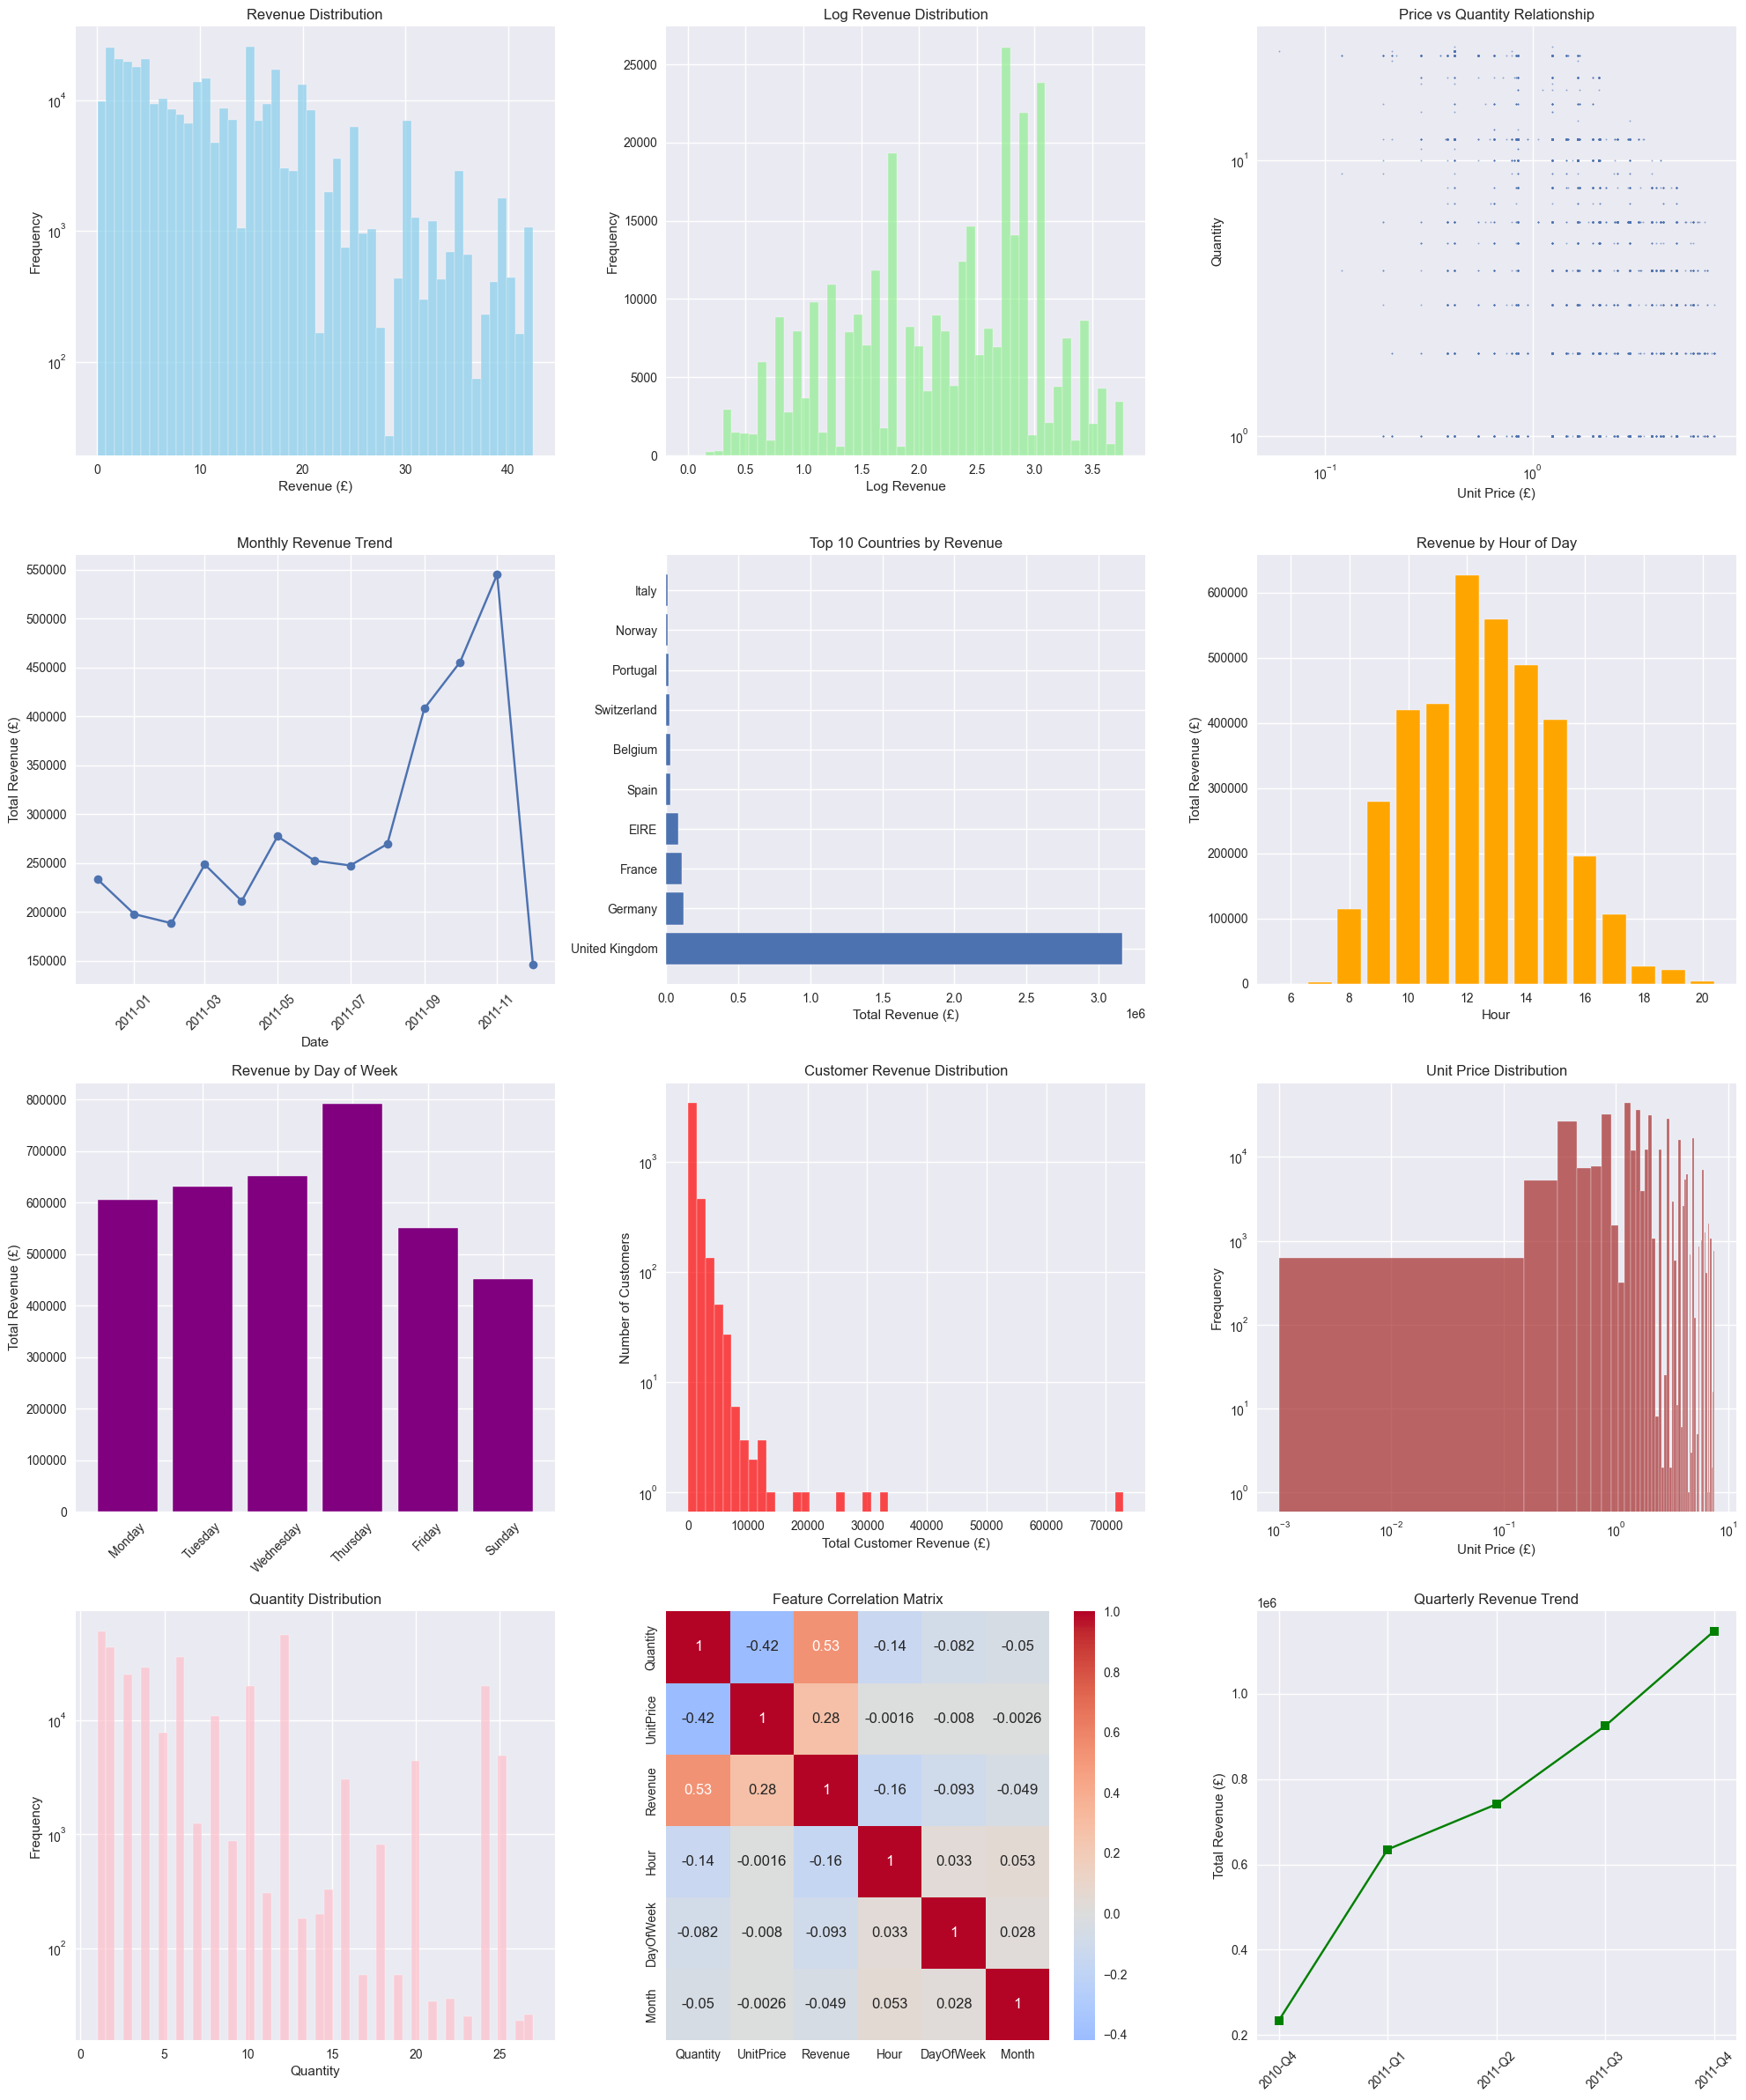

✓ Visualizations created successfully


True

In [144]:
create_visualizations(cleaned_data)

In [145]:
def feature_engineering(df):
    """
    Advanced feature engineering for predictive modeling
    """
    print("\n5. FEATURE ENGINEERING FOR PREDICTIVE MODELING")
    print("-" * 50)
    
    # Create advanced features
    df_features = df.copy()
    
    # Price-based features
    df_features['PriceCategory'] = pd.cut(df_features['UnitPrice'], 
                                        bins=[0, 1, 5, 10, 50, float('inf')], 
                                        labels=['Low', 'Medium', 'High', 'Premium', 'Luxury'])
    
    # Quantity-based features
    df_features['QuantityCategory'] = pd.cut(df_features['Quantity'], 
                                           bins=[0, 1, 5, 10, 50, float('inf')], 
                                           labels=['Single', 'Small', 'Medium', 'Large', 'Bulk'])
    
    # Time-based features
    df_features['IsWeekend'] = (df_features['DayOfWeek'] >= 5).astype(int)
    df_features['IsBusinessHour'] = ((df_features['Hour'] >= 9) & (df_features['Hour'] <= 17)).astype(int)
    
    # Customer behavior features
    df_features['RevenuePenQuantity'] = df_features['Revenue'] / df_features['Quantity']
    df_features['CustomerFrequency'] = df_features['TransactionCount']
    df_features['CustomerValue'] = df_features['TotalRevenue']
    
    # Seasonal features
    df_features['IsDecember'] = (df_features['Month'] == 12).astype(int)  # Holiday season
    df_features['IsQ4'] = (df_features['Quarter'] == 4).astype(int)
    
    # Create RFM (Recency, Frequency, Monetary) features
    reference_date = df_features['InvoiceDate'].max()
    rfm_features = df_features.groupby('CustomerID').agg({
        'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
        'InvoiceNo': 'nunique',  # Frequency
        'Revenue': 'sum'  # Monetary
    }).reset_index()
    
    rfm_features.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
    df_features = df_features.merge(rfm_features, on='CustomerID', how='left')
    
    print(f"✓ Created advanced features")
    print(f"✓ Feature set expanded to {df_features.shape[1]} columns")
    
    # Prepare features for modeling
    feature_columns = [
        'Quantity', 'UnitPrice', 'Hour', 'DayOfWeek', 'Month', 'Quarter',
        'CountryEncoded', 'IsWeekend', 'IsBusinessHour', 'IsDecember', 'IsQ4',
        'AvgRevenue', 'TransactionCount', 'TotalQuantity', 'AvgQuantity',
        'AvgPrice', 'CustomerLifespan', 'Recency', 'Frequency', 'Monetary'
    ]
    
    # Remove rows with any missing values in feature columns
    df_features = df_features.dropna(subset=feature_columns + ['Revenue'])
    
    print(f"✓ Final feature set prepared with {len(feature_columns)} predictors")
    print(f"✓ Clean dataset for modeling: {df_features.shape[0]:,} records")
    
    return df_features, feature_columns

In [146]:
engineered_data, feature_cols = feature_engineering(cleaned_data)


5. FEATURE ENGINEERING FOR PREDICTIVE MODELING
--------------------------------------------------
✓ Created advanced features
✓ Feature set expanded to 42 columns
✓ Final feature set prepared with 20 predictors
✓ Clean dataset for modeling: 328,638 records


In [147]:
def implement_linear_regression(X_train, X_test, y_train, y_test):
    """
    Implement and evaluate Linear Regression model
    """
    print("\n6.1 LINEAR REGRESSION MODEL")
    print("-" * 40)
    
    # Initialize and train model
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # Make predictions
    y_pred_train = lr_model.predict(X_train)
    y_pred_test = lr_model.predict(X_test)
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    
    print(f"Training RMSE: {train_rmse:.4f}")
    print(f"Testing RMSE: {test_rmse:.4f}")
    print(f"Training R²: {train_r2:.4f}")
    print(f"Testing R²: {test_r2:.4f}")
    print(f"Training MAE: {train_mae:.4f}")
    print(f"Testing MAE: {test_mae:.4f}")
    
    # Cross-validation
    cv_scores = cross_val_score(lr_model, X_train, y_train, cv=5, scoring='r2')
    print(f"Cross-validation R² (mean ± std): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    
    return lr_model, {
        'train_rmse': train_rmse, 'test_rmse': test_rmse,
        'train_r2': train_r2, 'test_r2': test_r2,
        'train_mae': train_mae, 'test_mae': test_mae,
        'cv_r2_mean': cv_scores.mean(), 'cv_r2_std': cv_scores.std()
    }

def implement_xgboost(X_train, X_test, y_train, y_test):
    """
    Implement and evaluate XGBoost model with hyperparameter tuning
    """
    print("\n6.2 XGBOOST REGRESSION MODEL")
    print("-" * 40)
    
    # Initialize XGBoost model
    xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1
    )
    
    # Train model
    xgb_model.fit(X_train, y_train)
    
    # Make predictions
    y_pred_train = xgb_model.predict(X_train)
    y_pred_test = xgb_model.predict(X_test)
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    
    print(f"Training RMSE: {train_rmse:.4f}")
    print(f"Testing RMSE: {test_rmse:.4f}")
    print(f"Training R²: {train_r2:.4f}")
    print(f"Testing R²: {test_r2:.4f}")
    print(f"Training MAE: {train_mae:.4f}")
    print(f"Testing MAE: {test_mae:.4f}")
    
    # Cross-validation
    cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='r2')
    print(f"Cross-validation R² (mean ± std): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': xgb_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\nTop 10 Most Important Features:")
    print(feature_importance.head(10))
    
    return xgb_model, {
        'train_rmse': train_rmse, 'test_rmse': test_rmse,
        'train_r2': train_r2, 'test_r2': test_r2,
        'train_mae': train_mae, 'test_mae': test_mae,
        'cv_r2_mean': cv_scores.mean(), 'cv_r2_std': cv_scores.std(),
        'feature_importance': feature_importance
    }
    
def implement_random_forest(X_train, X_test, y_train, y_test):
    """
    Implement and evaluate Random Forest Regression model
    """
    print("\n6.3 RANDOM FOREST REGRESSION MODEL")
    print("-" * 40)
    
    # Initialize model
    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    )
    
    # Train model
    rf_model.fit(X_train, y_train)
    
    # Make predictions
    y_pred_train = rf_model.predict(X_train)
    y_pred_test = rf_model.predict(X_test)
    
    # Evaluate
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    
    print(f"Training RMSE: {train_rmse:.4f}")
    print(f"Testing RMSE: {test_rmse:.4f}")
    print(f"Training R²: {train_r2:.4f}")
    print(f"Testing R²: {test_r2:.4f}")
    print(f"Training MAE: {train_mae:.4f}")
    print(f"Testing MAE: {test_mae:.4f}")
    
    # Cross-validation
    cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='r2')
    print(f"Cross-validation R² (mean ± std): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\nTop 10 Most Important Features:")
    print(feature_importance.head(10))
    
    return rf_model, {
        'train_rmse': train_rmse, 'test_rmse': test_rmse,
        'train_r2': train_r2, 'test_r2': test_r2,
        'train_mae': train_mae, 'test_mae': test_mae,
        'cv_r2_mean': cv_scores.mean(), 'cv_r2_std': cv_scores.std(),
        'feature_importance': feature_importance
    }

In [148]:
# Feature engineering
df_features, feature_columns = feature_engineering(cleaned_data)

# Define Targets and Features 
X = df_features[feature_columns]
y = df_features['Revenue']

# Splitting the data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


5. FEATURE ENGINEERING FOR PREDICTIVE MODELING
--------------------------------------------------
✓ Created advanced features
✓ Feature set expanded to 42 columns
✓ Final feature set prepared with 20 predictors
✓ Clean dataset for modeling: 328,638 records


In [149]:
# Linear Regression model 
lr_model, lr_metrics = implement_linear_regression(X_train, X_test, y_train, y_test)

# XGBoost model
xgb_model, xgb_metrics = implement_xgboost(X_train, X_test, y_train, y_test)

# Random forest model 
rf_model, rf_metrics = implement_random_forest(X_train, X_test, y_train, y_test)


6.1 LINEAR REGRESSION MODEL
----------------------------------------
Training RMSE: 5.5525
Testing RMSE: 5.5641
Training R²: 0.6008
Testing R²: 0.5982
Training MAE: 3.9711
Testing MAE: 3.9796
Cross-validation R² (mean ± std): 0.6006 ± 0.0033

6.2 XGBOOST REGRESSION MODEL
----------------------------------------
Training RMSE: 0.0891
Testing RMSE: 0.0917
Training R²: 0.9999
Testing R²: 0.9999
Training MAE: 0.0451
Testing MAE: 0.0453
Cross-validation R² (mean ± std): 0.9999 ± 0.0000

Top 10 Most Important Features:
             feature  importance
0           Quantity    0.605799
1          UnitPrice    0.270415
11        AvgRevenue    0.123236
17           Recency    0.000120
14       AvgQuantity    0.000095
19          Monetary    0.000073
15          AvgPrice    0.000066
18         Frequency    0.000054
12  TransactionCount    0.000047
6     CountryEncoded    0.000043

6.3 RANDOM FOREST REGRESSION MODEL
----------------------------------------
Training RMSE: 0.0109
Testing RMSE: 0.02

In [150]:
def customer_segmentation_analysis(df):
    """
    Perform customer segmentation for pricing strategy
    """
    print("\n7. CUSTOMER SEGMENTATION AND PRICING ANALYSIS")
    print("-" * 50)
    
    # RFM Analysis
    reference_date = df['InvoiceDate'].max()
    rfm_df = df.groupby('CustomerID').agg({
        'InvoiceDate': lambda x: (reference_date - x.max()).days,
        'InvoiceNo': 'nunique',
        'Revenue': 'sum'
    }).reset_index()
    
    rfm_df.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
    
    # Create RFM scores
    rfm_df['R_Score'] = pd.qcut(rfm_df['Recency'], 5, labels=[5,4,3,2,1])
    rfm_df['F_Score'] = pd.qcut(rfm_df['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
    rfm_df['M_Score'] = pd.qcut(rfm_df['Monetary'], 5, labels=[1,2,3,4,5])
    
    # Create RFM segments
    rfm_df['RFM_Score'] = rfm_df['R_Score'].astype(str) + rfm_df['F_Score'].astype(str) + rfm_df['M_Score'].astype(str)
    
    # Define customer segments
    def segment_customers(row):
        if row['RFM_Score'] in ['555', '554', '544', '545', '454', '455', '445']:
            return 'Champions'
        elif row['RFM_Score'] in ['543', '444', '435', '355', '354', '345', '344', '335']:
            return 'Loyal Customers'
        elif row['RFM_Score'] in ['512', '511', '422', '421', '412', '411', '311']:
            return 'Potential Loyalists'
        elif row['RFM_Score'] in ['533', '532', '531', '523', '522', '521', '515', '514']:
            return 'New Customers'
        elif row['RFM_Score'] in ['155', '154', '144', '214', '215', '115', '114']:
            return 'At Risk'
        elif row['RFM_Score'] in ['155', '154', '144', '214', '215', '115']:
            return 'Cannot Lose Them'
        else:
            return 'Others'
    
    rfm_df['Segment'] = rfm_df.apply(segment_customers, axis=1)
    
    # Analyze segments
    segment_analysis = rfm_df.groupby('Segment').agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary': ['mean', 'count']
    }).round(2)
    
    print("Customer Segment Analysis:")
    print(segment_analysis)
    
    # Price sensitivity analysis by segment
    customer_segments = df.merge(rfm_df[['CustomerID', 'Segment']], on='CustomerID', how='left')
    price_sensitivity = customer_segments.groupby('Segment').agg({
        'UnitPrice': ['mean', 'std', 'median'],
        'Quantity': ['mean', 'std', 'median'],
        'Revenue': ['mean', 'std', 'median']
    }).round(2)
    
    print("\nPrice Sensitivity by Segment:")
    print(price_sensitivity)
    
    return rfm_df, segment_analysis, price_sensitivity, customer_segments

In [151]:
rfm_df, segment_analysis, price_sensitivity, customer_segments = customer_segmentation_analysis(df_features)


7. CUSTOMER SEGMENTATION AND PRICING ANALYSIS
--------------------------------------------------
Customer Segment Analysis:
                    Recency Frequency Monetary      
                       mean      mean     mean count
Segment                                             
At Risk              202.77      3.00   983.20    57
Champions             10.77     10.64  2572.04   813
Loyal Customers       37.55      4.89  1242.24   421
New Customers          6.81      1.86   273.55   149
Others               135.87      1.98   377.54  2496
Potential Loyalists   27.57      1.03   133.47   218

Price Sensitivity by Segment:
                    UnitPrice              Quantity              Revenue  \
                         mean   std median     mean   std median    mean   
Segment                                                                    
At Risk                  2.32  1.58   1.85     8.44  6.47    6.0   13.86   
Champions                2.12  1.49   1.65     7.17  6.56    5.

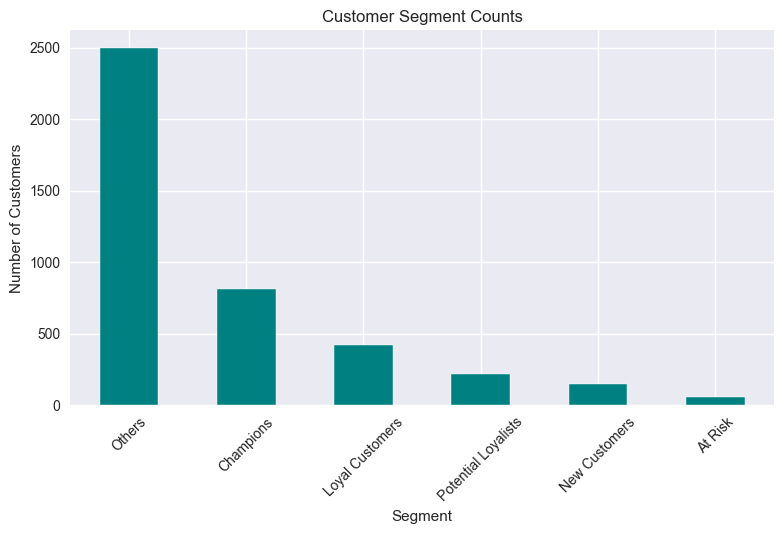

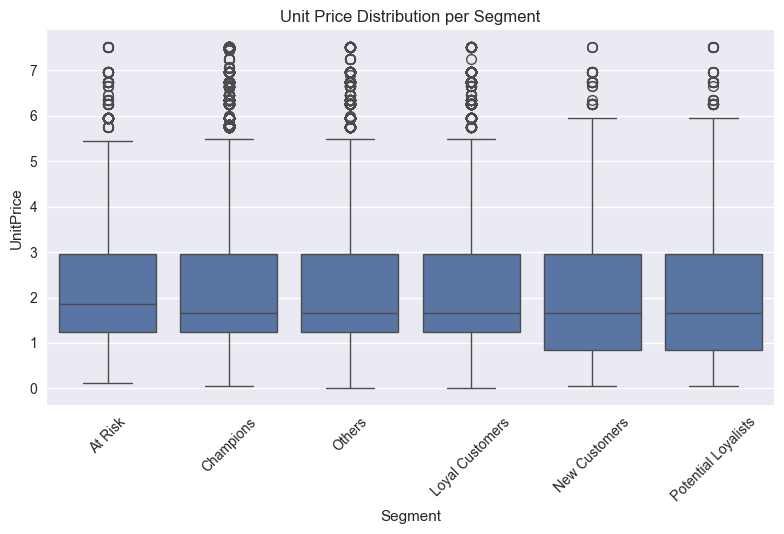

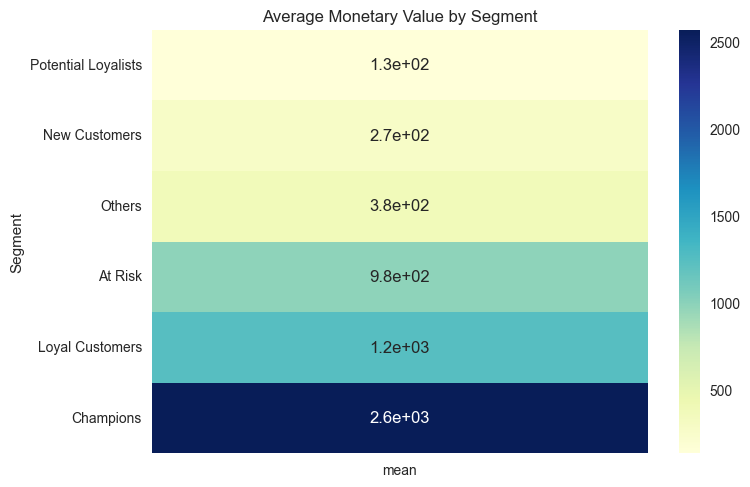

In [152]:
# Segment Size 
rfm_df['Segment'].value_counts().plot(kind='bar', color='teal')
plt.title('Customer Segment Counts')
plt.ylabel('Number of Customers')
plt.xlabel('Segment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Price Sensitivity Per Segment 
sns.boxplot(data=customer_segments, x='Segment', y='UnitPrice')
plt.xticks(rotation=45)
plt.title('Unit Price Distribution per Segment')
plt.tight_layout()
plt.show()

# Monetary Value by Segment 
monetary_means = segment_analysis['Monetary']['mean'].sort_values()
sns.heatmap(monetary_means.to_frame(), annot=True, cmap='YlGnBu')
plt.title('Average Monetary Value by Segment')
plt.show()

In [153]:
def dynamic_pricing_simulation(df):
    """
    Simulate dynamic pricing scenarios with enhanced analytics
    """
    print("\n8. DYNAMIC PRICING SIMULATION")
    print("-" * 50)
    
    # Select a sample of products for simulation
    top_products = df.groupby('Description')['Revenue'].sum().sort_values(ascending=False).head(10)
    simulation_results = []
    
    for product in top_products.index:
        product_data = df[df['Description'] == product].copy()
        
        if len(product_data) < 10:  # Skip products with insufficient data
            continue
            
        # Current metrics
        current_price = product_data['UnitPrice'].mean()
        current_quantity = product_data['Quantity'].mean()
        current_revenue = product_data['Revenue'].sum()
        
        # Simulate price changes
        price_changes = [-0.2, -0.1, 0, 0.1, 0.2]  # -20% to +20%
        
        for price_change in price_changes:
            new_price = current_price * (1 + price_change)
            
            # Estimate demand elasticity (simplified)
            # Assume price elasticity of -1.5 (typical for retail)
            price_elasticity = -1.5
            quantity_change = price_elasticity * price_change
            new_quantity = current_quantity * (1 + quantity_change)
            
            # Ensure quantity doesn't go negative
            new_quantity = max(0, new_quantity)
            
            # Calculate new revenue
            new_revenue = new_price * new_quantity * len(product_data)
            revenue_change = (new_revenue - current_revenue) / current_revenue
            
            simulation_results.append({
                'Product': product[:50],  # Truncate long product names
                'Price_Change': f"{price_change*100:+.0f}%",
                'Current_Price': current_price,
                'New_Price': new_price,
                'Current_Quantity': current_quantity,
                'New_Quantity': new_quantity,
                'Current_Revenue': current_revenue,
                'New_Revenue': new_revenue,
                'Revenue_Change': f"{revenue_change*100:+.1f}%",
                'Revenue_Change_Numeric': revenue_change
            })
    
    simulation_df = pd.DataFrame(simulation_results)
    print("Dynamic Pricing Simulation Results (Top 5 Products):")
    print(simulation_df.head(25))  # Show first 25 rows (5 products × 5 price scenarios)
    
    return simulation_df



8. DYNAMIC PRICING SIMULATION
--------------------------------------------------
Dynamic Pricing Simulation Results (Top 5 Products):
                               Product Price_Change  Current_Price  New_Price  \
0   WHITE HANGING HEART T-LIGHT HOLDER         -20%       2.961218   2.368974   
1   WHITE HANGING HEART T-LIGHT HOLDER         -10%       2.961218   2.665096   
2   WHITE HANGING HEART T-LIGHT HOLDER          +0%       2.961218   2.961218   
3   WHITE HANGING HEART T-LIGHT HOLDER         +10%       2.961218   3.257340   
4   WHITE HANGING HEART T-LIGHT HOLDER         +20%       2.961218   3.553462   
5              JUMBO BAG RED RETROSPOT         -20%       2.057044   1.645635   
6              JUMBO BAG RED RETROSPOT         -10%       2.057044   1.851339   
7              JUMBO BAG RED RETROSPOT          +0%       2.057044   2.057044   
8              JUMBO BAG RED RETROSPOT         +10%       2.057044   2.262748   
9              JUMBO BAG RED RETROSPOT         +20%    

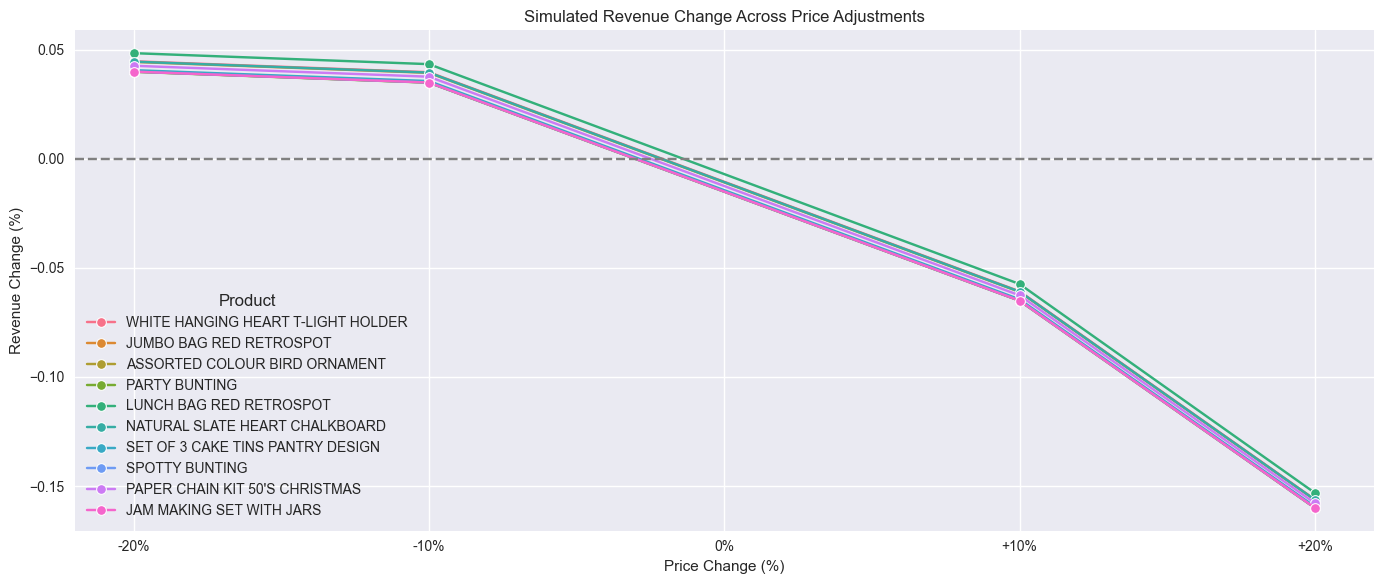

In [154]:
simulation_results = dynamic_pricing_simulation(df_features)

# Convert Price_Change to a categorical variable for ordering
simulation_results['Price_Change'] = pd.Categorical(
    simulation_results['Price_Change'],
    categories=['-20%', '-10%', '0%', '+10%', '+20%'],
    ordered=True
)

# Plot revenue change per product across price changes
plt.figure(figsize=(14, 6))
sns.lineplot(
    data=simulation_results,
    x='Price_Change',
    y='Revenue_Change_Numeric',
    hue='Product',
    marker='o'
)
plt.axhline(0, color='gray', linestyle='--')
plt.title('Simulated Revenue Change Across Price Adjustments')
plt.ylabel('Revenue Change (%)')
plt.xlabel('Price Change (%)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [155]:
def analyze_pricing_optimization(simulation_df):
    """
    Analyze optimal pricing strategies from simulation results
    """
    print("\n9. PRICING OPTIMIZATION ANALYSIS")
    print("-" * 50)
    
    # Find optimal price for each product
    optimal_prices = []
    
    for product in simulation_df['Product'].unique():
        product_sim = simulation_df[simulation_df['Product'] == product]
        
        # Find the price change that maximizes revenue
        max_revenue_idx = product_sim['Revenue_Change_Numeric'].idxmax()
        optimal_row = product_sim.loc[max_revenue_idx]
        
        optimal_prices.append({
            'Product': product,
            'Optimal_Price_Change': optimal_row['Price_Change'],
            'Optimal_Price': optimal_row['New_Price'],
            'Current_Price': optimal_row['Current_Price'],
            'Max_Revenue_Increase': optimal_row['Revenue_Change'],
            'Potential_Revenue': optimal_row['New_Revenue']
        })
    
    optimal_df = pd.DataFrame(optimal_prices)
    print("Optimal Pricing Strategy for Each Product:")
    print(optimal_df.to_string(index=False))
    
    return optimal_df


9. PRICING OPTIMIZATION ANALYSIS
--------------------------------------------------
Optimal Pricing Strategy for Each Product:
                           Product Optimal_Price_Change  Optimal_Price  Current_Price Max_Revenue_Increase  Potential_Revenue
WHITE HANGING HEART T-LIGHT HOLDER                 -20%       2.368974       2.961218                +4.5%       28240.543715
           JUMBO BAG RED RETROSPOT                 -20%       1.645635       2.057044                +4.4%       25885.838431
     ASSORTED COLOUR BIRD ORNAMENT                 -20%       1.352000       1.690000                +4.0%       23936.754400
                     PARTY BUNTING                 -20%       3.945706       4.932133                +4.0%       23508.124591
           LUNCH BAG RED RETROSPOT                 -20%       1.336040       1.670050                +4.8%       17015.936089
   NATURAL SLATE HEART CHALKBOARD                  -20%       2.384264       2.980330                +4.5%       164

C:\Users\ahman\AppData\Local\Temp\ipykernel_13776\3701206514.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=optimal_pricing_df, x='Product', y='Potential_Revenue', palette='Blues_d')


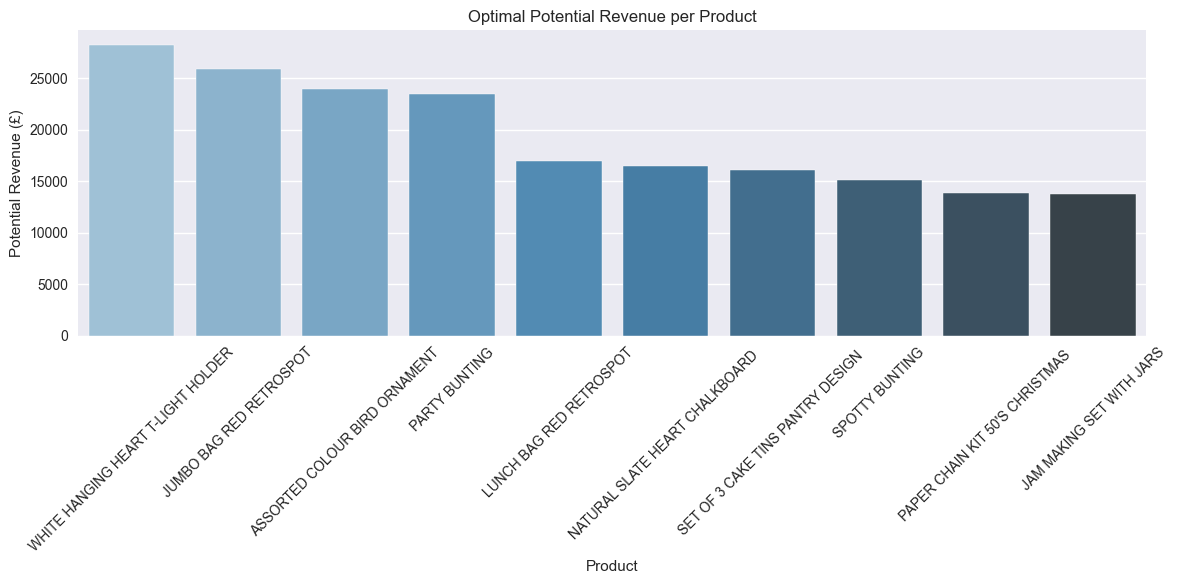

In [156]:
optimal_pricing_df = analyze_pricing_optimization(simulation_results)

plt.figure(figsize=(12, 6))
sns.barplot(data=optimal_pricing_df, x='Product', y='Potential_Revenue', palette='Blues_d')
plt.title('Optimal Potential Revenue per Product')
plt.ylabel('Potential Revenue (£)')
plt.xlabel('Product')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [157]:
def create_pricing_visualizations(simulation_df):
    """
    Create comprehensive visualizations for pricing analysis
    """
    print("\n10. PRICING VISUALIZATION")
    print("-" * 50)
    
    # Set up the plotting style
    plt.style.use('seaborn-v0_8')
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Dynamic Pricing Analysis Dashboard', fontsize=16, fontweight='bold')
    
    # 1. Revenue Change by Price Change
    ax1 = axes[0, 0]
    price_changes = [-20, -10, 0, 10, 20]
    avg_revenue_changes = []
    
    for pc in price_changes:
        price_str = f"{pc:+.0f}%"
        avg_change = simulation_df[simulation_df['Price_Change'] == price_str]['Revenue_Change_Numeric'].mean()
        avg_revenue_changes.append(avg_change * 100)
    
    bars = ax1.bar(price_changes, avg_revenue_changes, 
                   color=['red' if x < 0 else 'green' for x in avg_revenue_changes])
    ax1.set_xlabel('Price Change (%)')
    ax1.set_ylabel('Average Revenue Change (%)')
    ax1.set_title('Average Revenue Impact by Price Change')
    ax1.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, value in zip(bars, avg_revenue_changes):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                f'{value:.1f}%', ha='center', va='bottom')
    
    # 2. Product-wise Revenue Optimization
    ax2 = axes[0, 1]
    products = simulation_df['Product'].unique()[:5]  # Top 5 products
    
    for product in products:
        product_data = simulation_df[simulation_df['Product'] == product]
        price_changes_num = [float(pc.rstrip('%')) for pc in product_data['Price_Change']]
        revenue_changes = [float(rc.rstrip('%')) for rc in product_data['Revenue_Change']]
        ax2.plot(price_changes_num, revenue_changes, marker='o', label=product[:20])
    
    ax2.set_xlabel('Price Change (%)')
    ax2.set_ylabel('Revenue Change (%)')
    ax2.set_title('Revenue Response by Product')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.grid(True, alpha=0.3)
    
    # 3. Price Elasticity Heatmap
    ax3 = axes[1, 0]
    
    # Create a pivot table for heatmap
    pivot_data = simulation_df.pivot_table(
        values='Revenue_Change_Numeric', 
        index='Product', 
        columns='Price_Change', 
        aggfunc='mean'
    )
    
    # Select top 5 products for better visualization
    pivot_data = pivot_data.head(5)
    
    im = ax3.imshow(pivot_data.values, cmap='RdYlGn', aspect='auto')
    ax3.set_xticks(range(len(pivot_data.columns)))
    ax3.set_xticklabels(pivot_data.columns)
    ax3.set_yticks(range(len(pivot_data.index)))
    ax3.set_yticklabels([prod[:20] for prod in pivot_data.index])
    ax3.set_xlabel('Price Change')
    ax3.set_ylabel('Products')
    ax3.set_title('Revenue Change Heatmap')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax3)
    cbar.set_label('Revenue Change (%)')
    
    # 4. Optimal Pricing Distribution
    ax4 = axes[1, 1]
    
    # Find optimal price change for each product
    optimal_changes = []
    for product in simulation_df['Product'].unique():
        product_sim = simulation_df[simulation_df['Product'] == product]
        max_revenue_idx = product_sim['Revenue_Change_Numeric'].idxmax()
        optimal_change = float(product_sim.loc[max_revenue_idx, 'Price_Change'].rstrip('%'))
        optimal_changes.append(optimal_change)
    
    ax4.hist(optimal_changes, bins=5, color='skyblue', alpha=0.7, edgecolor='black')
    ax4.set_xlabel('Optimal Price Change (%)')
    ax4.set_ylabel('Number of Products')
    ax4.set_title('Distribution of Optimal Price Changes')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig



8. DYNAMIC PRICING SIMULATION
--------------------------------------------------
Dynamic Pricing Simulation Results (Top 5 Products):
                               Product Price_Change  Current_Price  New_Price  \
0   WHITE HANGING HEART T-LIGHT HOLDER         -20%       2.961218   2.368974   
1   WHITE HANGING HEART T-LIGHT HOLDER         -10%       2.961218   2.665096   
2   WHITE HANGING HEART T-LIGHT HOLDER          +0%       2.961218   2.961218   
3   WHITE HANGING HEART T-LIGHT HOLDER         +10%       2.961218   3.257340   
4   WHITE HANGING HEART T-LIGHT HOLDER         +20%       2.961218   3.553462   
5              JUMBO BAG RED RETROSPOT         -20%       2.057044   1.645635   
6              JUMBO BAG RED RETROSPOT         -10%       2.057044   1.851339   
7              JUMBO BAG RED RETROSPOT          +0%       2.057044   2.057044   
8              JUMBO BAG RED RETROSPOT         +10%       2.057044   2.262748   
9              JUMBO BAG RED RETROSPOT         +20%    

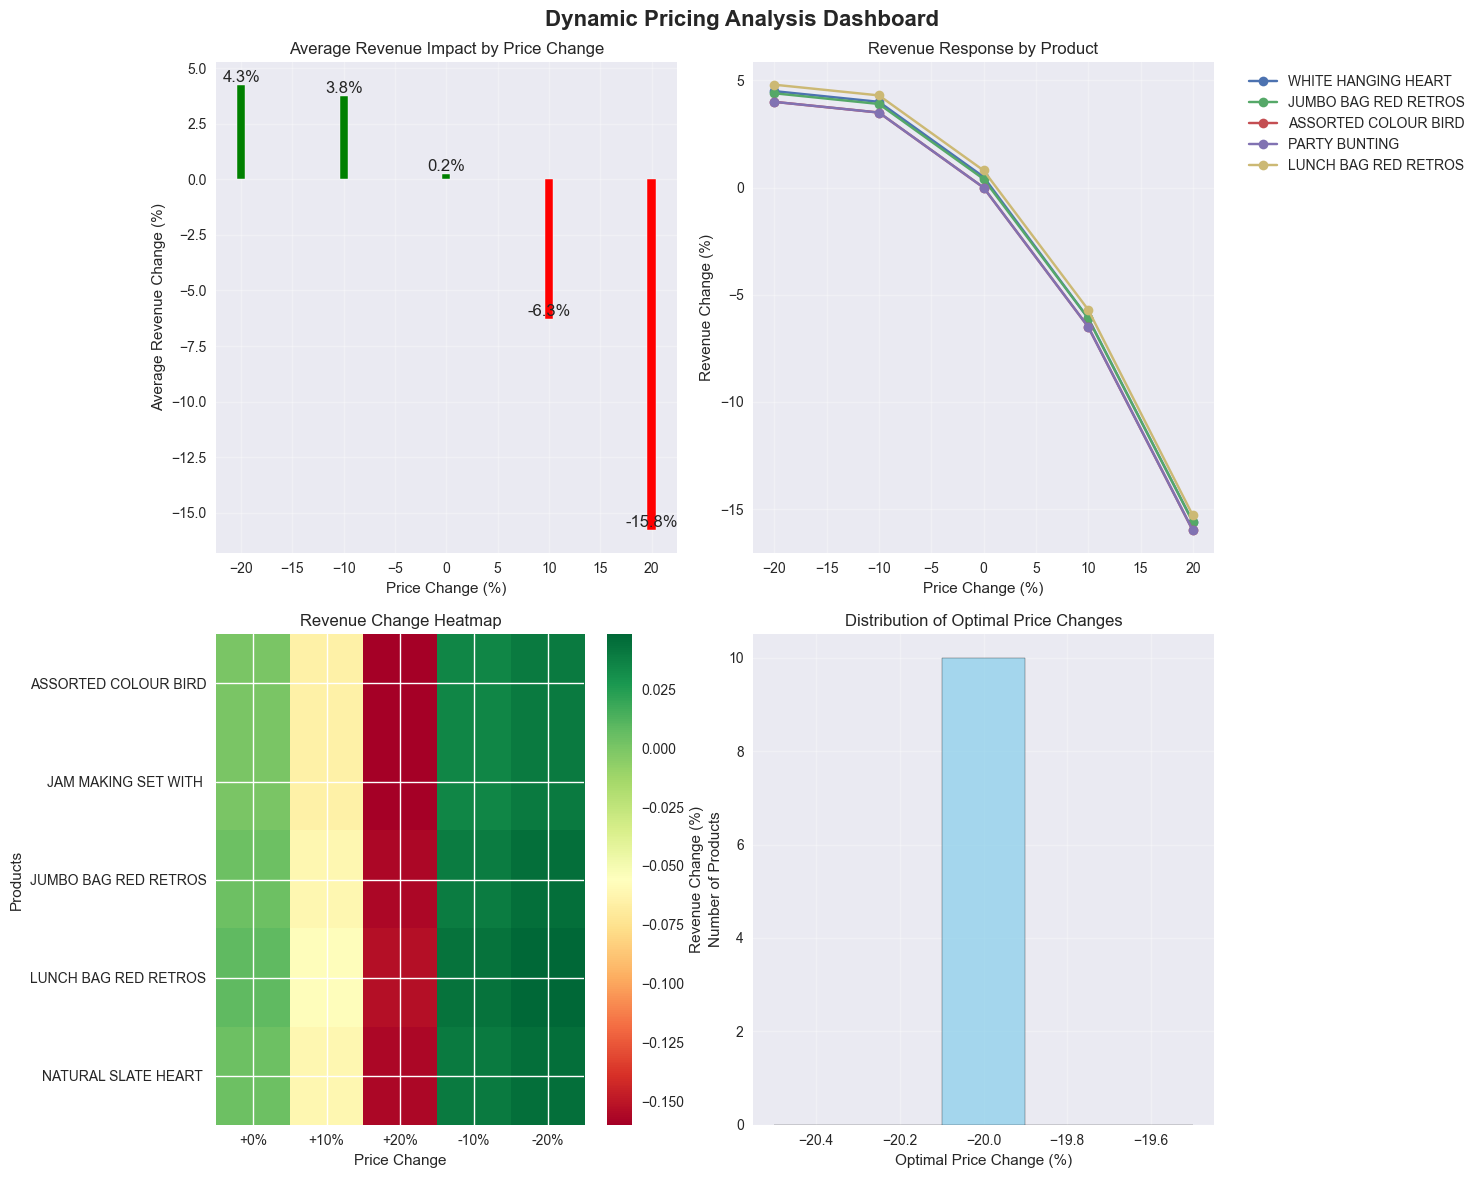

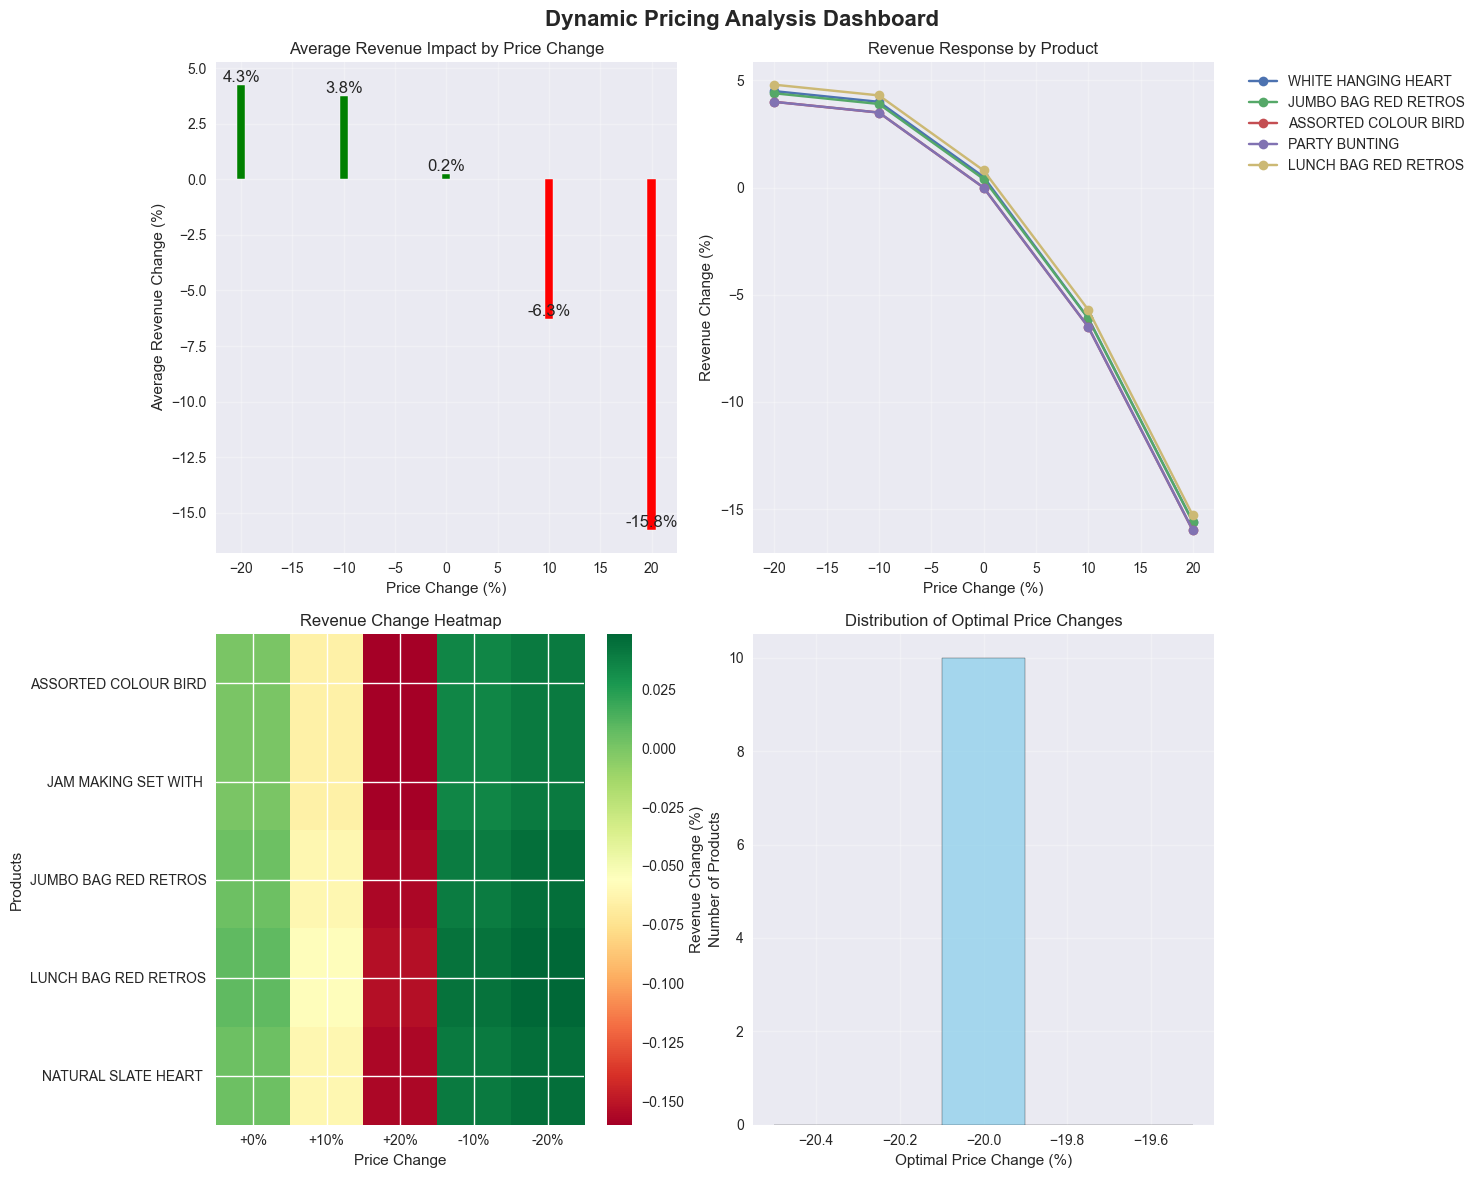

In [158]:
simulation_df = dynamic_pricing_simulation(cleaned_data)
create_pricing_visualizations(simulation_df)

In [159]:
def generate_pricing_recommendations(simulation_df, optimal_df):
    """
    Generate actionable pricing recommendations
    """
    print("\n11. PRICING RECOMMENDATIONS")
    print("-" * 50)
    
    recommendations = []
    
    for _, row in optimal_df.iterrows():
        product = row['Product']
        optimal_change = row['Optimal_Price_Change']
        revenue_increase = row['Max_Revenue_Increase']
        
        # Determine recommendation type
        if optimal_change == '+0%':
            recommendation_type = "MAINTAIN"
            action = "Keep current pricing"
        elif '+' in optimal_change:
            recommendation_type = "INCREASE"
            action = f"Increase price by {optimal_change}"
        else:
            recommendation_type = "DECREASE"
            action = f"Decrease price by {optimal_change}"
        
        # Risk assessment
        revenue_change_num = float(revenue_increase.rstrip('%'))
        if revenue_change_num > 10:
            risk_level = "LOW"
        elif revenue_change_num > 5:
            risk_level = "MEDIUM"
        else:
            risk_level = "HIGH"
        
        recommendations.append({
            'Product': product,
            'Recommendation': recommendation_type,
            'Action': action,
            'Expected_Revenue_Increase': revenue_increase,
            'Risk_Level': risk_level,
            'Priority': 'HIGH' if revenue_change_num > 10 else 'MEDIUM' if revenue_change_num > 5 else 'LOW'
        })
    
    recommendations_df = pd.DataFrame(recommendations)
    
    print("PRICING RECOMMENDATIONS SUMMARY:")
    print("=" * 70)
    
    # Summary statistics
    increase_count = len(recommendations_df[recommendations_df['Recommendation'] == 'INCREASE'])
    decrease_count = len(recommendations_df[recommendations_df['Recommendation'] == 'DECREASE'])
    maintain_count = len(recommendations_df[recommendations_df['Recommendation'] == 'MAINTAIN'])
    
    print(f"Products to INCREASE price: {increase_count}")
    print(f"Products to DECREASE price: {decrease_count}")
    print(f"Products to MAINTAIN price: {maintain_count}")
    print()
    
    # High priority recommendations
    high_priority = recommendations_df[recommendations_df['Priority'] == 'HIGH']
    if len(high_priority) > 0:
        print("HIGH PRIORITY RECOMMENDATIONS:")
        print(high_priority[['Product', 'Action', 'Expected_Revenue_Increase']].to_string(index=False))
        print()
    
    # Risk analysis
    print("RISK ANALYSIS:")
    risk_summary = recommendations_df['Risk_Level'].value_counts()
    for risk, count in risk_summary.items():
        print(f"{risk} Risk: {count} products")
    
    return recommendations_df

In [160]:
optimal_df = analyze_pricing_optimization(simulation_df)

# Generate and display pricing recommendations
recommendations_df = generate_pricing_recommendations(simulation_df, optimal_df)


9. PRICING OPTIMIZATION ANALYSIS
--------------------------------------------------
Optimal Pricing Strategy for Each Product:
                           Product Optimal_Price_Change  Optimal_Price  Current_Price Max_Revenue_Increase  Potential_Revenue
WHITE HANGING HEART T-LIGHT HOLDER                 -20%       2.368974       2.961218                +4.5%       28240.543715
           JUMBO BAG RED RETROSPOT                 -20%       1.645635       2.057044                +4.4%       25885.838431
     ASSORTED COLOUR BIRD ORNAMENT                 -20%       1.352000       1.690000                +4.0%       23936.754400
                     PARTY BUNTING                 -20%       3.945706       4.932133                +4.0%       23508.124591
           LUNCH BAG RED RETROSPOT                 -20%       1.336040       1.670050                +4.8%       17015.936089
   NATURAL SLATE HEART CHALKBOARD                  -20%       2.384264       2.980330                +4.5%       164

In [161]:
def create_implementation_guide(recommendations_df):
    """
    Create a step-by-step implementation guide with guaranteed output
    """
    print("\n12. IMPLEMENTATION GUIDE")
    print("-" * 50)
    
    print("STEP-BY-STEP PRICING IMPLEMENTATION:")
    print("=" * 50)

    print(f"\nTotal Recommendations Received: {len(recommendations_df)}")
    print("Available Columns:", recommendations_df.columns.tolist())

    # Phase 1: High Priority, Low Risk
    phase1 = recommendations_df[
        (recommendations_df['Priority'] == 'HIGH') & 
        (recommendations_df['Risk_Level'] == 'LOW')
    ]
    print(f"\nPHASE 1 - IMMEDIATE IMPLEMENTATION ({len(phase1)} products):")
    print("-" * 60)
    if len(phase1) > 0:
        for _, row in phase1.iterrows():
            print(f"• {row['Product'][:40]}: {row['Action']}")
            print(f"  Expected Revenue Increase: {row['Expected_Revenue_Increase']}\n")
    else:
        print("No products meet the criteria.\n")
    
    # Phase 2: Medium Priority or Medium Risk
    phase2 = recommendations_df[
        (recommendations_df['Priority'] == 'MEDIUM') | 
        (recommendations_df['Risk_Level'] == 'MEDIUM')
    ]
    print(f"\nPHASE 2 - GRADUAL IMPLEMENTATION ({len(phase2)} products):")
    print("-" * 60)
    if len(phase2) > 0:
        for _, row in phase2.iterrows():
            print(f"• {row['Product'][:40]}: {row['Action']}")
            print(f"  Expected Revenue Increase: {row['Expected_Revenue_Increase']}\n")
    else:
        print("No products meet the criteria.\n")
    
    # Phase 3: High Risk
    phase3 = recommendations_df[recommendations_df['Risk_Level'] == 'HIGH']
    print(f"\nPHASE 3 - TEST AND MONITOR ({len(phase3)} products):")
    print("-" * 60)
    if len(phase3) > 0:
        print("Implement with A/B testing and close monitoring:")
        for _, row in phase3.iterrows():
            print(f"• {row['Product'][:40]}: {row['Action']}")
            print(f"  Expected Revenue Increase: {row['Expected_Revenue_Increase']}\n")
    else:
        print("No products meet the criteria.\n")
    
    print("\nMONITORING RECOMMENDATIONS:")
    print("-" * 30)
    print("• Monitor sales volume changes weekly")
    print("• Track customer satisfaction metrics")
    print("• Adjust pricing based on competitor analysis")
    print("• Review and update pricing strategy monthly")
    print("• Consider seasonal factors and market conditions")

In [188]:
create_implementation_guide(recommendations_df)


12. IMPLEMENTATION GUIDE
--------------------------------------------------
STEP-BY-STEP PRICING IMPLEMENTATION:

Total Recommendations Received: 10
Available Columns: ['Product', 'Recommendation', 'Action', 'Expected_Revenue_Increase', 'Risk_Level', 'Priority']

PHASE 1 - IMMEDIATE IMPLEMENTATION (0 products):
------------------------------------------------------------
No products meet the criteria.


PHASE 2 - GRADUAL IMPLEMENTATION (0 products):
------------------------------------------------------------
No products meet the criteria.


PHASE 3 - TEST AND MONITOR (10 products):
------------------------------------------------------------
Implement with A/B testing and close monitoring:
• WHITE HANGING HEART T-LIGHT HOLDER: Decrease price by -20%
  Expected Revenue Increase: +4.5%

• JUMBO BAG RED RETROSPOT: Decrease price by -20%
  Expected Revenue Increase: +4.4%

• ASSORTED COLOUR BIRD ORNAMENT: Decrease price by -20%
  Expected Revenue Increase: +4.0%

• PARTY BUNTING: Decreas